In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import multiprocessing as mpp
import pickle
import os
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#from hpc_lib import SACCT_data_handler
from hpc_lib import *
#
import pandas
import pathlib

In [3]:

#
# get header, print a few rows:
#data_file_name = 'data/sacct_out.out'
#data_file_name = 'data/sacct_mazama_out.out'
data_file_name = 'data/sacct_sherlock_out_hns.out'
#data_file_name = 'data/sacct_sherlock_out_oneillm.out'
#
demo_file = 'data/demo_data.out'
with open(data_file_name, 'r') as fin:
    with open(demo_file,'w') as fout:
        for k in range(int(1e5)):
            fout.write(fin.readline())
            #
        #
    #
#
#
# translation dictionary. Note the column input parameters (aka, --format=...) are not the same as
#.  the colunm names.
#
# with -p --delimiter='|', we get:
#. ['User', 'JobID', 'JobName', 'Partition', 'State', 'Timelimit', 'Start', 'End',
#'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS', '']
#
# how well does PANDAS automagically handle types? Maybe we should just add all available columns to this:
# NOTE: System-,User-,Total-CPU is a string with multiple values (time, energy, etc.)
types_dict={'User':str, 'JobID':str, 'JobName':str, 'Partition':str, 'State':str,
            'Timelimit':hpc_lib.elapsed_time_2_day,'Start':str2date, 'End':str2date, 'Submit':str2date,
            'Elapsed':hpc_lib.elapsed_time_2_day, 'MaxRSS':str,
            'MaxVMSize':str, 'NNodes':int, 'NCPUS':int, 'MinCPU':str, 'SystemCPU':str, 'UserCPU':str,
            'TotalCPU':str}
delim = '|'

In [4]:
# How dtypes work in PANDAS:
#
# #data_df2['Submit']=mpd.datestr2num(data_df2['Submit'])
# print('** ', data_df2.dtypes)
# print('** ', data_df2.dtypes.index, data_df2.dtypes.values)
# for s in data_df2.dtypes.index: print('* ', s)
# print('** ** ', 'State' in data_df2.dtypes.index)
#
# print('** ', data_df2.columns )
# print('** ', len(data_df2.columns))
# #
# for s in data_df2.columns:
#     print('** ', s)

### HPC Usage data
- Presently focused on Mazama
- Usage data drawn via:
```
--format=User,JobID,Jobname,partition,state,time,start,end,elapsed,MaxRss,MaxVMSize,nnodes,ncpus
```
- Generally, type conversions will need to be performed manually
- But since we might change the columns of interest, let's code up a dictionary of functions to do the translation

In [5]:

with open(demo_file, 'r') as fin:
    # NOTE: lines end with a delimiter, so dump the last value.
    #
    headers = fin.readline()[:-1].split(delim)
    delim_lines=fin.readline()
    #
    #print('*** headers: ', headers)
    #
    teasers = []
    for k in range(10):
        #print('**')
        #teasers += [fin.readline()[:-1].split()]
        teasers += [fin.readline()[:-2]]
#
print('headers: ', headers)
for k,rw in enumerate(teasers):
    print('{}: {}'.format(k,rw))

headers:  ['User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', '']
0: |||extern|47861384.extern|47861384.extern||COMPLETED||20|1|2019-08-10T00:57:02|2019-08-10T00:57:02|2019-08-10T00:57:02|2019-08-17T00:57:29|7-00:00:27|00:00.001|00:00:00|00:00.001|1|12096540|00:00:00
1: ippoliti|vkhemani|357497|test|48057259_930|48215392|hns|COMPLETED|2-00:00:00|1|1|2019-08-12T15:03:44|2019-08-12T15:03:45|2019-08-14T02:04:17|2019-08-16T01:31:51|1-23:27:34|24:49.090|1-23:00:48|1-23:25:37||170854|00:00:00
2: |||batch|48057259_930.batch|48215392.batch||COMPLETED||1|1|2019-08-14T02:04:17|2019-08-14T02:04:17|2019-08-14T02:04:17|2019-08-16T01:31:51|1-23:27:34|24:49.089|1-23:00:48|1-23:25:37|1|170854|00:00:00
3: |||extern|48057259_930.extern|48215392.extern||COMPLETED||1|1|2019-08-14T02:04:17|2019-08-14T02:04:17|2019-08-14T02:04:17

In [6]:
sacct_demo = hpc_lib.SACCT_data_handler(data_file_name=demo_file, delim='|', max_rows=1000)

** DEBUG: jobs_summary.shape = (31736,)


In [7]:
#ff = sacct_demo.jobs_summary.tofile(fid='demo_summary.csv', )
sacct_demo.jobs_summary.dtype

dtype((numpy.record, [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('JobName', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', 'O'), ('UserCPU', 'O'), ('TotalCPU', 'O'), ('NTasks', 'O'), ('CPUTimeRAW', 'O'), ('Suspended', 'O'), ('JobID_parent', 'O')]))

In [15]:
pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
#
if not os.path.isfile(pkl_name):
    #
    #sacct_data = SACCT_data_handler(data_file_name=demo_file, delim='|', max_rows=1000)
    sacct_data = hpc_lib.SACCT_data_handler(data_file_name=data_file_name, delim='|')
    #
    print('** writing pickle file: {}'.format(pkl_name))
    with open(pkl_name, 'wb') as fout:
        #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
        out_pkl = pickle.dump(sacct_demo, fout)
    #
else:
    with open(pkl_name, 'rb') as fin:
        sacct_data = pickle.load(fin)
        #
    #
#   

 
#
ts = sacct_demo.jobs_summary['Start'][0:10]
print('** ', ts.shape)
print('** ', sacct_data.jobs_summary.shape, sacct_data.data.shape)
print('** ', sacct_data.data.dtype)
print('** ', sacct_data.jobs_summary.dtype)
print('\n\n** ', sacct_data.data['Start'][0])
print('** ', sacct_data.jobs_summary['Start'][0])
#
print('** ', sacct_data.jobs_summary['Start'][0:10])
print('** ', type(sacct_data.jobs_summary['Start'][0]))

**  (10,)
**  (560043,) (1710725,)
**  (numpy.record, [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('JobName', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', 'O'), ('UserCPU', 'O'), ('TotalCPU', 'O'), ('NTasks', 'O'), ('CPUTimeRAW', 'O'), ('Suspended', 'O'), ('JobID_parent', 'O')])
**  (numpy.record, [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('JobName', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', 'O'), ('UserCPU', 'O'), ('TotalCPU', 'O'), ('NTasks', 'O'), ('CPUTimeRAW', 'O'), ('Suspended', 'O'), ('JobID_parent', 'O')])


**  737281.0396064814
**  737285.96

In [16]:

#

In [17]:
#d_out = sacct_data.export_summary_data(output_path='data/hns_summary.csv')
output_path = 'data/hns_summary_out.csv'
delim = '\t'
print('** ', '%s{}'.format(delim))
ss = '%s{}'.format(delim)
print('** ** ', ss.join(['' for _ in sacct_data.headers]))

print('* {} * {}'.format(len(sacct_data.headers), sacct_data.headers))
print('* {} * {}'.format(len(sacct_data.jobs_summary[0]), sacct_data.jobs_summary[0]))

# xx =  sacct_data.jobs_summary.tofile(output_path,
#                                         format=('%s{}'.format(delim)).join(['' for _ in sacct_data.headers]),
#                                      sep='\n')

# with open('demo_summary.csv', 'r') as fin:
#     #for k,rw in enumerate(fin):
#     #    print('** ', rw)
#     #    if k>10: break
#     #    #
#     #
#     S = fin.read(800)
#     print('** ', S)
#     print('** * ', S.find('\t'))
# #

**  %s	
** **  %s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	
* 24 * ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'JobID_parent')
* 24 * (79, 'lbgee', 'solomone', '45032', 'DCHImCpdII', '47768519', '47768519', 'hns', 'TIMEOUT', 7., 20, 1, 737285.8237037, 737285.82510417, 737285.96518519, 737292.96532407, 7.00011574, '5-02:30:58', '120-06:01:12', '125-08:32:10', None, '12096200', '00:00:00', '47768519')


** DEBUG:  (560043,) (560043,)


Text(0.5, 0, 'time $t$')

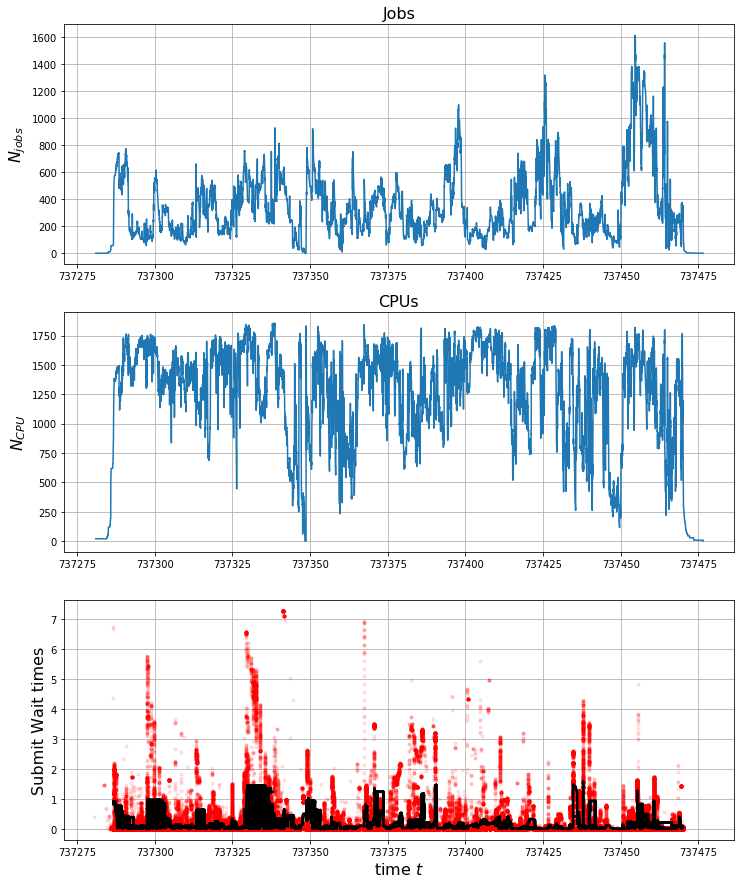

In [69]:
cpu_usage = sacct_data.active_jobs_cpu()
#
submit_times = sacct_data.jobs_summary['Start'] - sacct_data.jobs_summary['Submit']
n_sm = 1000
ix = numpy.argsort(sacct_data.jobs_summary['Submit'])
submit_times_sm = hpc_lib.running_mean(submit_times[ix], n=n_sm)

#cpu_usage = sacct_demo.active_jobs_cpu()

fg = plt.figure(figsize=(12,15))
ax1 = plt.subplot('311')
#ax1a = ax1.twinx()
ax2 = plt.subplot('312', sharex=ax1)
ax3 = plt.subplot('313', sharex=ax1)
#
ax1.grid()
ax2.grid()
ax3.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-')
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-')
#
ln, = ax1a.plot(sacct_data.jobs_summary['Submit'][n_sm:], submit_times_sm, ls='-', marker='', lw=2.5,
                color='k', alpha=1., zorder=11)
clr = ln.get_color()

ix = numpy.argsort(sacct_data.jobs_summary['Submit'][n_sm:])
ax3.plot((sacct_data.jobs_summary['Submit'][n_sm:]), submit_times_sm[ix], ls='-', marker='', lw=2.5, 
          color='k', alpha=1., zorder=11)
ax3.plot(sacct_data.jobs_summary['Submit'], submit_times, ls='', marker='.', lw=2.5, color='r',
         alpha=.1)



#
ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)
#
ax1a.set_ylabel('Submit Wait times', size=16)
ax3.set_ylabel('Submit Wait times', size=16)
#
ax3.set_xlabel('time $t$', size=16)

In [19]:

wait_stats = sacct_data.get_wait_stats()

***  0 0.5
***  1 0.8
***  2 0.95


(0, 3.0)

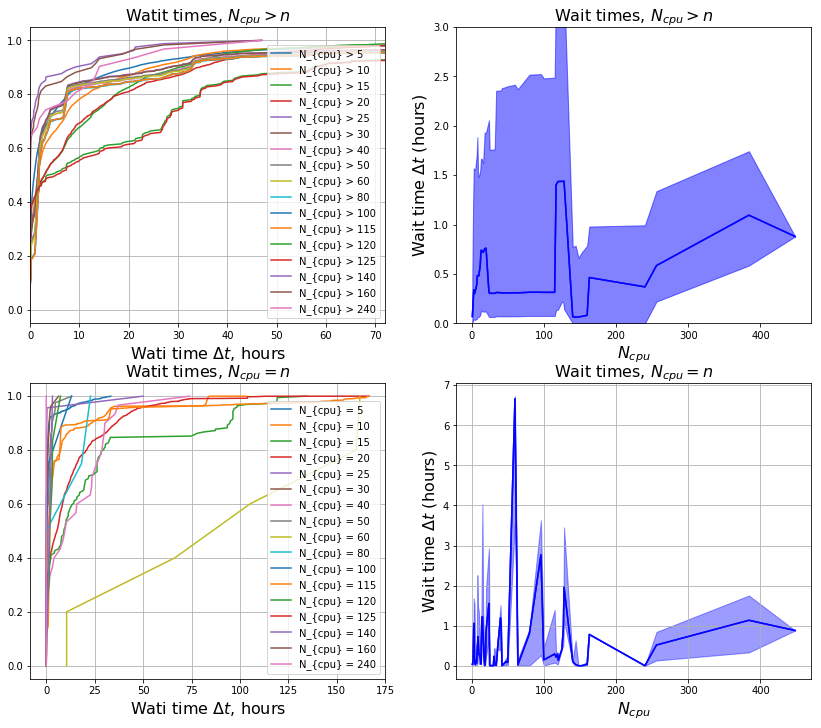

In [70]:
# Cumulative distributrions of wait times, as a function of n_cpu. Not trivially simple how we want 
#. to tell this story.
#
fg = plt.figure(figsize=(14,12))
ax1 = plt.subplot('221')
ax2 = plt.subplot('222')
#
ax3 = plt.subplot('223')
ax4 = plt.subplot('224')
#
for ax in (ax1, ax2, ax3, ax4):
    ax.grid()
#
quantiles = []
quantiles_lt = []
quantiles_eq = []
qs = [.5, .8, .95]

#
#len(numpy.unique(wait_stats['ncpus']))
for n in (wait_stats['ncpus']):
    if n==0: continue
    #
    
    #n = int(n)
    #X = wait_stats[wait_stats['ncpus']==n] 
    #
    xx_gt = numpy.array(sorted( (sacct_data.jobs_summary['Start'] -
                              sacct_data.jobs_summary['Submit'])[sacct_data.jobs_summary['NCPUS']>=n] ))
    xx_lt = numpy.array(sorted( (sacct_data.jobs_summary['Start'] -
                              sacct_data.jobs_summary['Submit'])[sacct_data.jobs_summary['NCPUS']<=n] ))
    xx_eq = numpy.array(sorted( (sacct_data.jobs_summary['Start'] -
                              sacct_data.jobs_summary['Submit'])[sacct_data.jobs_summary['NCPUS']==n] ))
    quantiles += [[n] + list(numpy.quantile(xx_gt, qs))]
    quantiles_lt += [[n] + list(numpy.quantile(xx_lt, qs))]
    quantiles_eq += [[n] + list(numpy.quantile(xx_eq, qs))]
    #
    #print('*** ', n, len(xx) )
    
    #print('** {}/{}'.format(len(X), len(wait_stats)))
    #
    if n%5==0:
        ax1.plot(xx_gt*24., numpy.linspace(0., 1., len(xx_gt)), ls='-', label='N_{{cpu}} > {}'.format(n))
        #
        ax3.plot(xx_eq*24., numpy.linspace(0., 1., len(xx_eq)), ls='-', label='N_{{cpu}} = {}'.format(n))
#
quantiles = numpy.array(quantiles)
quantiles_lt = numpy.array(quantiles_lt)
quantiles_eq = numpy.array(quantiles_eq)
#
ax1.legend(loc=0)
ax3.legend(loc=0)
#
ax1.set_xlim(0,72)
ax1.set_title('Watit times, $N_{cpu}>n$', size=16)
ax1.set_xlabel('Wati time $\Delta t$, hours', size=16)
#
ax3.set_title('Watit times, $N_{cpu}=n$', size=16)
ax3.set_xlabel('Wati time $\Delta t$, hours', size=16)
#
#
for k,q in enumerate(qs):
    print('*** ', k,q)
    ax2.plot(quantiles[:,0], quantiles[:,2], label='$q={}$'.format(q), alpha=.7, color='b')
    ax2.fill_between(quantiles[:,0], quantiles[:,1], quantiles[:,quantiles.shape[1]-1], alpha=.2, color='b')
    #
    ax4.plot(quantiles_eq[:,0], quantiles_eq[:,2], label='$q={}$'.format(q), alpha=.7, color='b')
    ax4.fill_between(quantiles_eq[:,0], quantiles_eq[:,1],
                     quantiles_eq[:,quantiles_eq.shape[1]-1], alpha=.15, color='b')
#
ax2.set_ylabel('Wait time $\Delta t$ (hours)', size=16)
ax2.set_xlabel('$N_{cpu}$', size=16)
ax2.set_title('Wait times, $N_{cpu}>n$', size=16)
#
ax4.set_ylabel('Wait time $\Delta t$ (hours)', size=16)
ax4.set_xlabel('$N_{cpu}$', size=16)
ax4.set_title('Wait times, $N_{cpu}=n$', size=16)
#
ax2.grid()
ax2.set_ylim(0, 3.)

### Compute volume statistics
- Similar to cpu-count wait time stats, but compute wait times for 'compute volume,' $V = n_{cpu} \cdot \Delta t$.
- $\Delta t$ should be the requested wall-time, but preliminary estimates muight use the run-time, which we have computed.
- Note: it is a little bit difficult to produce an analog of the $N_{cpu}$ statistics, since cvompute volume is not an integer. Basicalluy, we need to do some binning or something.


***  [7.   7.   6.25 2.   2.   2.   2.   2.   2.   2.  ]
**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'JobID_parent')


Text(0, 0.5, 'Submit wait time, $\\Delta t_w$')

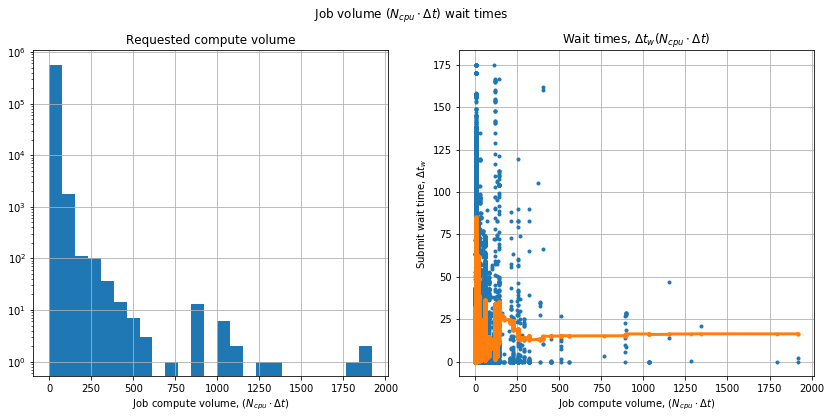

In [74]:
fg = plt.figure(figsize=(14,6))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
ax1.grid()
ax2.grid()
#
#time_limits = numpy.array([hpc_lib.elapsed_time_2_day(s) for s in sacct_data.jobs_summary['Timelimit']])
time_limits = sacct_data.jobs_summary['Timelimit']

req_volume = time_limits*sacct_data.jobs_summary['NCPUS']
ix_sort = numpy.argsort(req_volume)
#
#hh = plt.hist(time_limits, 25, log=True)
hh = ax1.hist(req_volume, 25, log=True)
#
dts = 24.*(sacct_data.jobs_summary['Start']-sacct_data.jobs_summary['Submit'])
#
ax2.plot(req_volume[ix_sort], dts[ix_sort], ls='', marker='.')
n=200
ax2.plot((req_volume[ix_sort])[n:], hpc_lib.running_mean(dts[ix_sort],n), ls='-', marker='.', lw=3., zorder=11)
#ax2.set_ylim([-.2, 2.5])
#ax2.set_xlim(-10., 1000.)
#
print('*** ', sacct_data.jobs_summary['Timelimit'][0:10])
#print('*** ', sacct_data.data['Timelimit'][0:10])
print('** ', sacct_data.jobs_summary.dtype.names)
#
plt.suptitle('Job volume ($N_{cpu} \cdot \Delta t$) wait times')
ax1.set_title('Requested compute volume')
ax1.set_xlabel('Job compute volume, ($N_{cpu} \cdot \Delta t$)')
ax2.set_title('Wait times, $\Delta t_w (N_{cpu} \cdot \Delta t)$')
ax2.set_xlabel('Job compute volume, ($N_{cpu} \cdot \Delta t$)')
ax2.set_ylabel('Submit wait time, $\Delta t_w$')

***  0 0.5
***  1 0.75
***  2 0.99


Text(0.5, 0, 'Wait time (hours)')

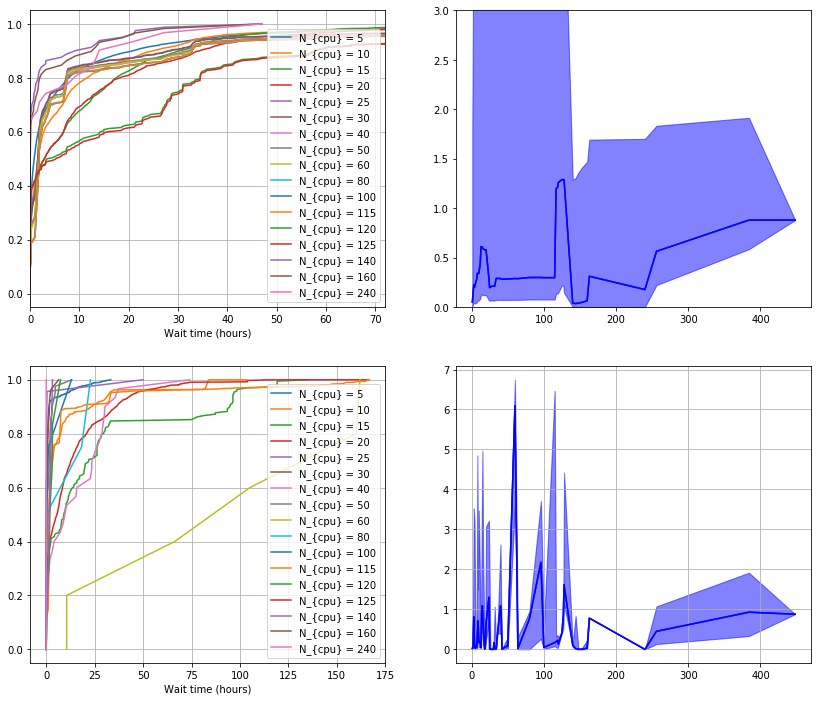

In [22]:
# Cumulative distributrions of wait times, as a function of n_cpu*run-time. Not trivially simple how we want 
#. to tell this story.
# note that this should be requested wall-time, but i'm not sure we have that.
#
fg = plt.figure(figsize=(14,12))
ax1 = plt.subplot('221')
ax2 = plt.subplot('222')
#
ax3 = plt.subplot('223')
ax4 = plt.subplot('224')
#
for ax in (ax1, ax2, ax3, ax4):
    ax.grid()
#
quantiles = []
quantiles_lt = []
qs = [.5, .75, .99]

#
#len(numpy.unique(wait_stats['ncpus']))
for n in (wait_stats['ncpus']):
    if n==0: continue
    #
    
    #n = int(n)
    #X = wait_stats[wait_stats['ncpus']==n] 
    #
    xx_gt = numpy.array(sorted( (sacct_data.jobs_summary['Start'] -
                              sacct_data.jobs_summary['Submit'])[sacct_data.jobs_summary['NCPUS']>=n] ))
    xx_lt = numpy.array(sorted( (sacct_data.jobs_summary['Start'] -
                              sacct_data.jobs_summary['Submit'])[sacct_data.jobs_summary['NCPUS']==n] ))
    quantiles += [[n] + list(numpy.quantile(xx_gt, qs))]
    quantiles_lt += [[n] + list(numpy.quantile(xx_lt, qs))]
    #
    #print('*** ', n, len(xx) )
    
    #print('** {}/{}'.format(len(X), len(wait_stats)))
    #
    if n%5==0:
        ax1.plot(xx_gt*24., numpy.linspace(0., 1., len(xx_gt)), ls='-', label='N_{{cpu}} = {}'.format(n))
        #
        ax3.plot(xx_lt*24., numpy.linspace(0., 1., len(xx_lt)), ls='-', label='N_{{cpu}} = {}'.format(n))
#
quantiles = numpy.array(quantiles)
quantiles_lt = numpy.array(quantiles_lt)
#
ax1.legend(loc=0)
ax1.set_xlim(0,72)
ax1.set_xlabel('Wait time (hours)')
#
#
for k,q in enumerate(qs):
    print('*** ', k,q)
    ax2.plot(quantiles[:,0], quantiles[:,2], label='$q={}$'.format(q), alpha=.7, color='b')
    ax2.fill_between(quantiles[:,0], quantiles[:,1], quantiles[:,quantiles.shape[1]-1], alpha=.2, color='b')
    #
    ax4.plot(quantiles_lt[:,0], quantiles_lt[:,2], label='$q={}$'.format(q), alpha=.7, color='b')
    ax4.fill_between(quantiles_lt[:,0], quantiles_lt[:,1],
                     quantiles_lt[:,quantiles_lt.shape[1]-1], alpha=.2, color='b')
#
ax2.grid()
ax2.set_ylim(0, 3.)
ax3.legend(loc=0)
ax3.set_xlabel('Wait time (hours)')

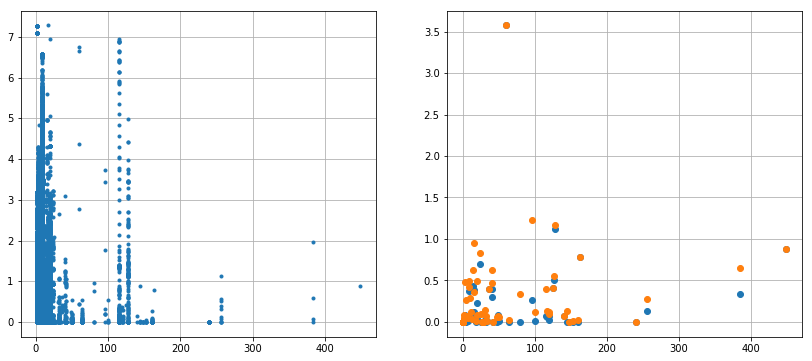

In [23]:
# def submit_wait_times(self):
#     submit_waits = self.summary_data['Start'] - self.summary_data['Submit']

X,Y = [sacct_data.jobs_summary['NCPUS'], sacct_data.jobs_summary['Start']-sacct_data.jobs_summary['Submit']]
ix = numpy.argsort(X)
#
fg = plt.figure(figsize=(14,6))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
ax1.grid()
ax2.grid()
#
ax1.plot(X[ix], Y[ix], ls='', marker='.')
#
ax2.plot(wait_stats['ncpus'], wait_stats['median'], ls='', marker='o')
ax2.plot(wait_stats['ncpus'], wait_stats['mean'], ls='', marker='o')
ax2.set_yscale=('log')




In [24]:
print('** ', sacct_data.jobs_summary['Start'][0:20])

**  [737285.96518519 737281.03960648 737285.88325231 737285.88743056
 737285.88743056 737285.88743056 737285.88743056 737285.88743056
 737285.88743056 737285.8890162  737285.8890162  737285.72668981
 737285.8890162  737285.8890162  737285.8890162  737285.72668981
 737285.8890162  737285.8890162  737285.8890162  737285.08630787]
